In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
from tqdm.auto import tqdm

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import torchvision

from torch.utils.tensorboard import SummaryWriter
from torch.optim import Adam, SGD

import numpy as np
import matplotlib.pyplot as plt

from utils import CelebA_dataset, MNIST_dataset, train_model

from model import NonLinearICA

# Train NonLinear ICA models

$h_i$ represent a single dimension (unmixed source, disentangled feature).

The total model output:

$$r(x, u) = \sum\limits_{i=1}^n \psi_i(h_i(\mathbf{x}), \mathbf{u})$$

The $\mathbf{u}$ should be "one-hot" encoded.

# CelebA

In [ ]:
train = torchvision.datasets.CelebA("data/CelebA", split="train", target_type=["attr", "identity"])
valid = torchvision.datasets.CelebA("data/CelebA", split="valid", target_type=["attr", "identity"])
test = torchvision.datasets.CelebA("data/CelebA", split="test", target_type=["attr", "identity"])

In [ ]:
type(train)

In [ ]:
batch_size=32

In [ ]:
train_dataloader = DataLoader(CelebA_dataset(train), batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(CelebA_dataset(valid), batch_size=batch_size)
test_dataloader = DataLoader(CelebA_dataset(test), batch_size=batch_size)

In [ ]:
hidden_dimension = 25
model = NonLinearICA(3, hidden_dimension, dropout=0.2, data_type='CelebA')

In [ ]:
epochs=35
lr = 0.01

log_dir = "logs/CelebA/"
device="cuda:9"

model = model.to(device)

In [ ]:
model = train_model(
    model, 
    train_dataloader, 
    valid_dataloader, 
    log_dir, 
    epochs=epochs, 
    lr=lr, 
    optimizer="SGD", 
    device=device
)

In [ ]:
# save the model
torch.save(model, log_dir + f"/model_n{hidden_dimension}")

# MNIST

## Load data

In [ ]:
train = torchvision.datasets.MNIST("data/MNIST", download=True, train=True)
test = torchvision.datasets.MNIST("data/MNIST", download=True, train=False)

In [ ]:
batch_size=32
train_dataloader = DataLoader(MNIST_dataset(train), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(MNIST_dataset(test), batch_size=batch_size)

## Train model

In [ ]:
hidden_dimension = 12
model = NonLinearICA(1, hidden_dimension, dropout=0.2, data_type='MNIST')

In [ ]:
epochs=25
lr=0.01

log_dir = "logs/MNIST/"

device="cuda:9"

model = model.to(device)

In [ ]:
model = train_model(
    model, 
    train_dataloader, 
    test_dataloader, 
    log_dir, 
    epochs=epochs, 
    lr=lr, 
    optimizer="SGD", 
    device=device
)

In [ ]:
# save the model
torch.save(model, log_dir + f"/model_n{hidden_dimension}")

## Investigate model features

### MNIST

In [3]:
log_dir = "logs/MNIST/"
hidden_dim = 12
model = torch.load(log_dir + f"model_n{hidden_dim}")

In [6]:
batch_size=32
device='cuda:9'

test = torchvision.datasets.MNIST("data/MNIST", download=True, train=False)
test_dataloader = DataLoader(MNIST_dataset(test), batch_size=batch_size)

In [7]:
model.eval()
images = []
labels = []
representations = []
with torch.no_grad():
    for x, u, u_star in tqdm(test_dataloader, desc="Calculating latent representations"):
        images.append(x.cpu())
        x = x.to(device)
        output = model.forward_h(x)
        representations.append(output.cpu())
        labels.append(u)
images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)
representations = torch.cat(representations, dim=0)
labels = (labels == 1).nonzero()[:, 1]
images = images.squeeze().numpy()

Calculating latent representations:   0%|          | 0/313 [00:00<?, ?it/s]

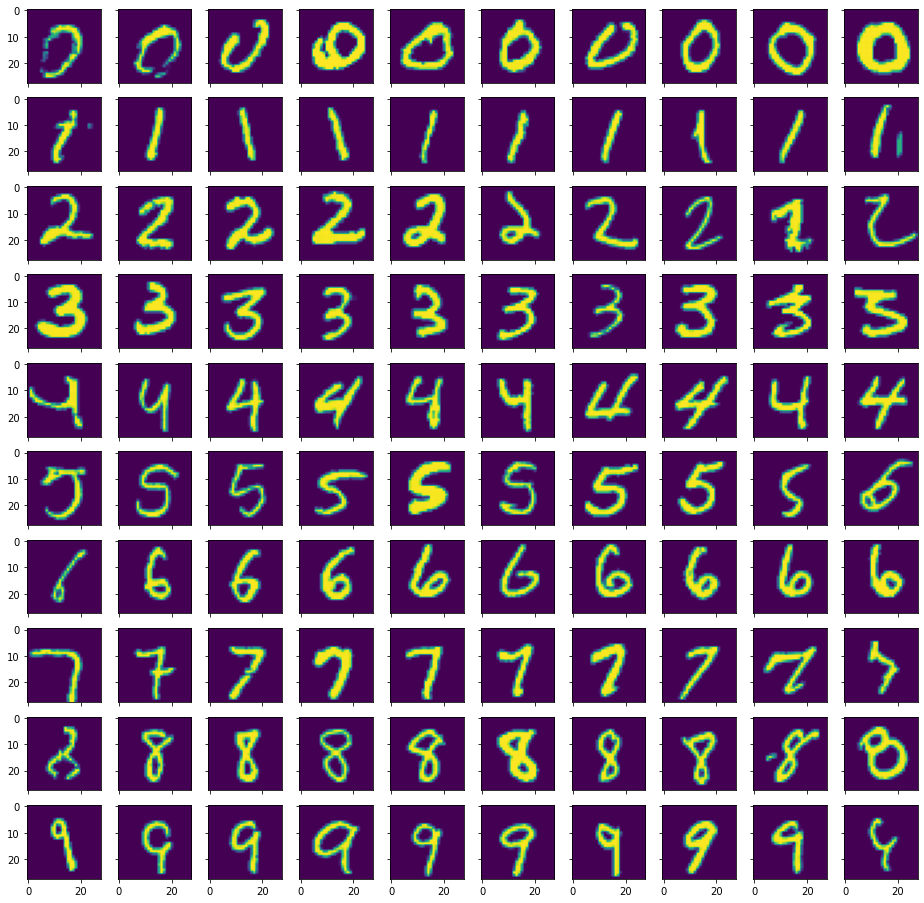

In [10]:
feature_id = 11
# inside one class
fig, axes = plt.subplots(10, 10, sharex=True, sharey=True, figsize=(16, 16))
for class_id in range(10):
    mask = (labels == class_id)
    masked_images = images[mask]
    masked_representations = representations[mask]
    
    ids = np.linspace(0, masked_images.shape[0]-1, 10, dtype=np.int16)
    sorted_ids = torch.argsort(masked_representations, dim=0)[ids, feature_id].numpy()
    selected_images = masked_images[sorted_ids]
    for i, ax in enumerate(axes[class_id]):
        ax.imshow(selected_images[i])
plt.show()

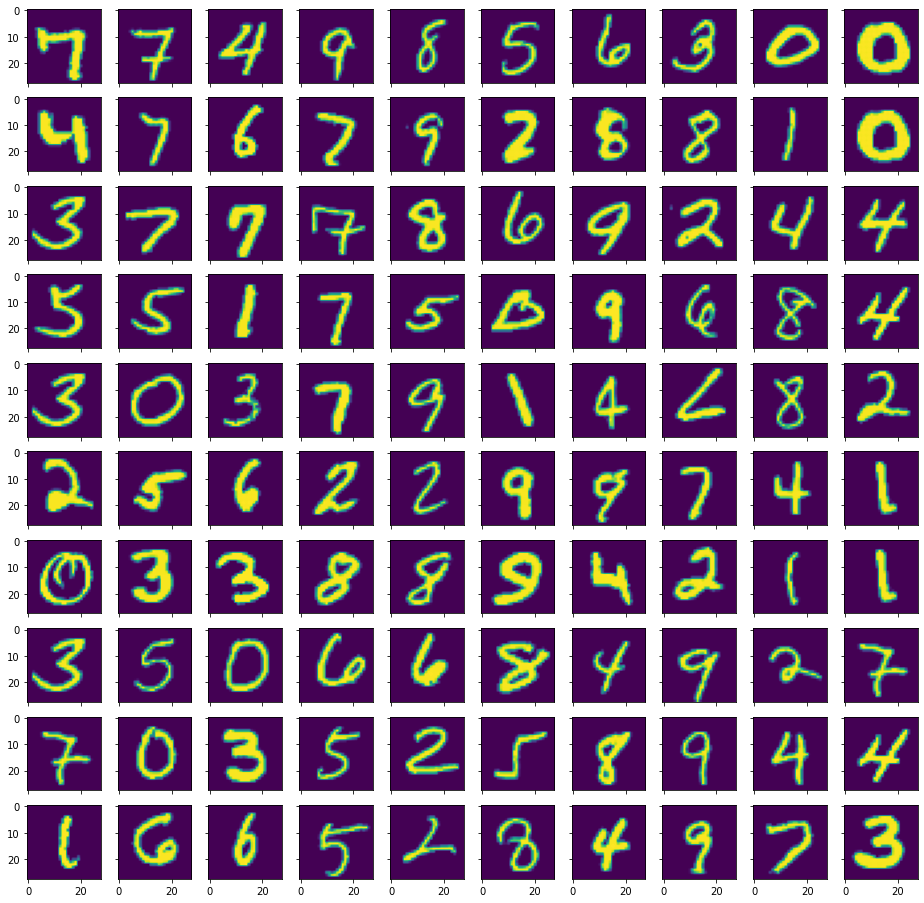

In [11]:
# inside one feature 
fig, axes = plt.subplots(10, 10, sharex = True, sharey=True, figsize=(16, 16))
for feature_id in range(10):
    ids = np.linspace(0, images.shape[0]-1, 10, dtype=np.int16)
    sorted_ids = torch.argsort(representations, dim=0)[ids, feature_id].numpy()
    selected_images = images[sorted_ids]
    for i, ax in enumerate(axes[feature_id]):
        ax.imshow(selected_images[i])
plt.show()

### CelebA

In [12]:
log_dir = "logs/CelebA/"
hidden_dim = 25
model = torch.load(log_dir + f"model_n{hidden_dim}")

In [13]:
test = torchvision.datasets.CelebA("data/CelebA", split="test", target_type=["attr", "identity"])

In [14]:
batch_size=32
test_dataloader = DataLoader(CelebA_dataset(test), batch_size=batch_size)

In [15]:
model.eval()
images = []
labels = []
representations = []
with torch.no_grad():
    for x, u, u_star in tqdm(test_dataloader, desc="Calculating latent representations"):
        images.append(x.cpu())
        x = x.to(device)
        output = model.forward_h(x)
        representations.append(output.cpu())
        labels.append(u)
images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)
representations = torch.cat(representations, dim=0)

Calculating latent representations:   0%|          | 0/624 [00:00<?, ?it/s]

In [16]:
images = images.moveaxis(1, -1)

In [17]:
chosen_attrs = ['Bald', 'Black_Hair', 'Blond_Hair', 'Eyeglasses', 'Male', 'Mustache',  'Smiling']
chosen_attr_ids = [np.argwhere(np.array(test.attr_names) == attr)[0][0] for attr in chosen_attrs]

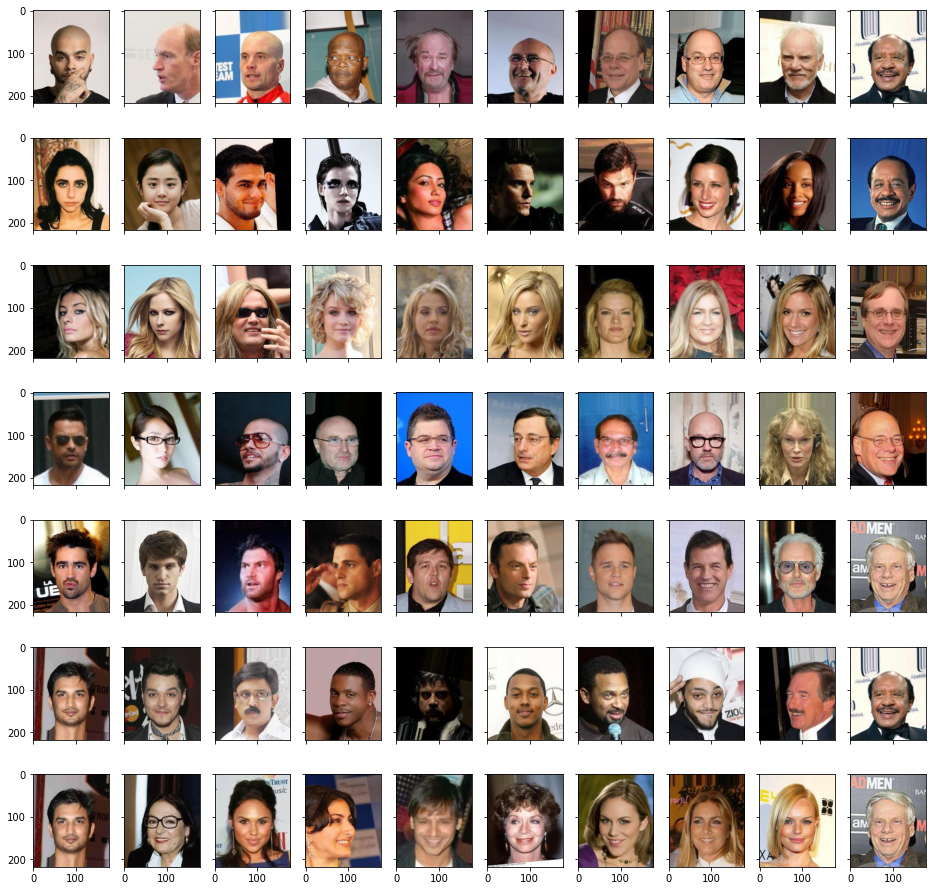

In [18]:
feature_id = 2
# inside one class
fig, axes = plt.subplots(len(chosen_attr_ids), 10, sharex=True, sharey=True, figsize=(16, 16))
for j, class_id in enumerate(chosen_attr_ids):
    mask = labels[:, class_id].bool()
    masked_images = images[mask]
    masked_representations = representations[mask]
    
    ids = np.linspace(0, masked_images.shape[0]-1, 10, dtype=np.int16)
    sorted_ids = torch.argsort(masked_representations, dim=0)[ids, feature_id].numpy()
    selected_images = masked_images[sorted_ids].numpy()
    for i, ax in enumerate(axes[j]):
        ax.imshow(selected_images[i]/256.0)
plt.show()

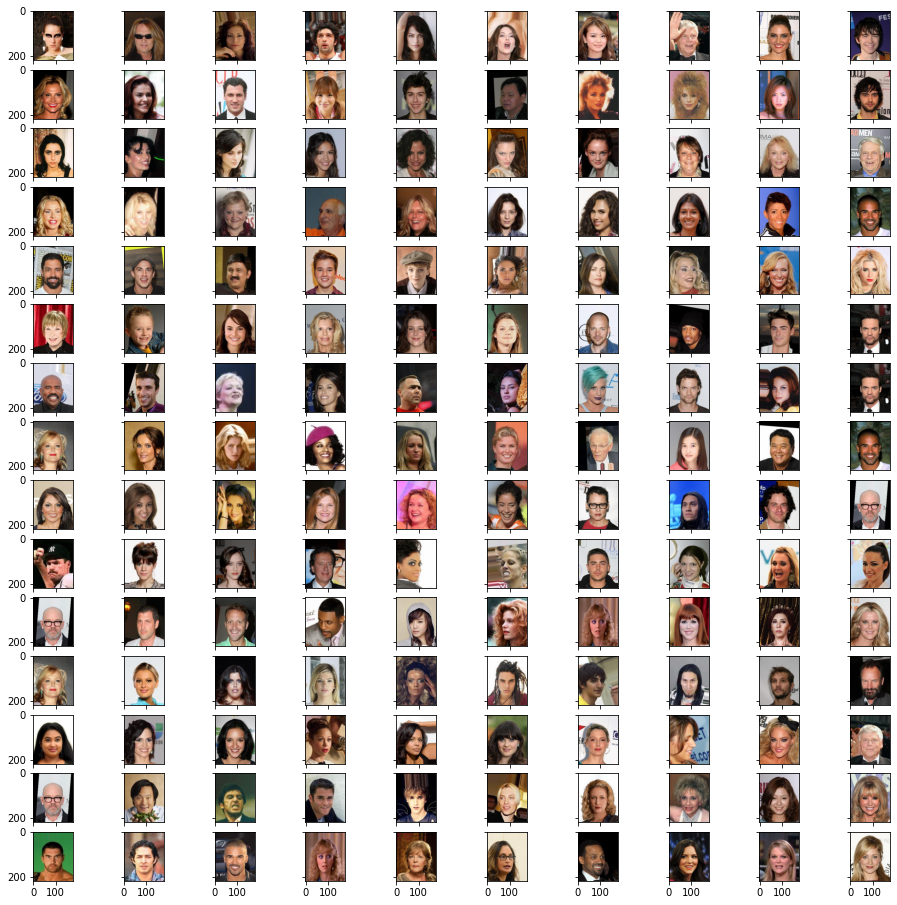

In [20]:
# inside one feature 
fig, axes = plt.subplots(15, 10, sharex = True, sharey=True, figsize=(16, 16))
for feature_id in range(15):
    ids = np.linspace(0, images.shape[0]-1, 10, dtype=np.int16)
    sorted_ids = torch.argsort(representations, dim=0)[ids, feature_id].numpy()
    selected_images = images[sorted_ids]
    for i, ax in enumerate(axes[feature_id]):
        ax.imshow(selected_images[i]/256.0)
plt.show()